In [1]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve()
if (REPO_ROOT / "src").exists() is False:
    # If you opened the notebook from inside /notebooks
    REPO_ROOT = REPO_ROOT.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
FIG_DIR = REPO_ROOT / "outputs" / "figures"
TAB_DIR = REPO_ROOT / "outputs" / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path.cwd().resolve()
candidates = [HERE, HERE.parent, HERE.parent.parent]

REPO_ROOT = None
for c in candidates:
    if (c / "src").exists():
        REPO_ROOT = c
        break

if REPO_ROOT is None:
    raise RuntimeError("Could not locate repo root containing /src.")

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.config import base_case
from src.model import run_deterministic_unit_econ, result_to_dict

In [4]:
base = base_case()
d = result_to_dict(run_deterministic_unit_econ(base))

print("Baseline contribution profit:", f"${d['contribution_profit']:,.0f}")

Baseline contribution profit: $-1,600,000


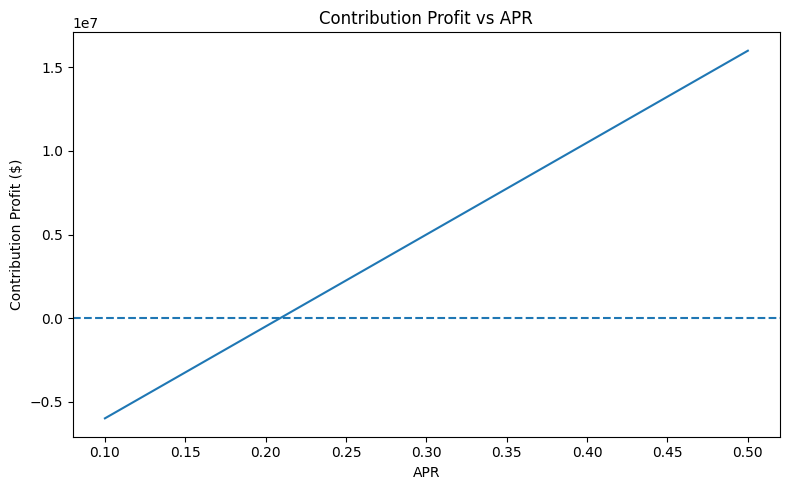

In [5]:
aprs = np.linspace(0.10, 0.50, 100)

profits = []

for apr in aprs:
    temp = base.model_copy(update={"apr": float(apr)})
    d = result_to_dict(run_deterministic_unit_econ(temp))
    profits.append(d["contribution_profit"])

profits = np.array(profits)

plt.figure(figsize=(8,5))
plt.plot(aprs, profits)
plt.axhline(0, linestyle="--")
plt.title("Contribution Profit vs APR")
plt.xlabel("APR")
plt.ylabel("Contribution Profit ($)")
plt.tight_layout()
plt.show()

In [6]:
# Find first APR where profit turns positive
break_even_apr = aprs[np.where(profits > 0)[0][0]]
print("Approximate break-even APR:", round(float(break_even_apr), 4))

Approximate break-even APR: 0.2091


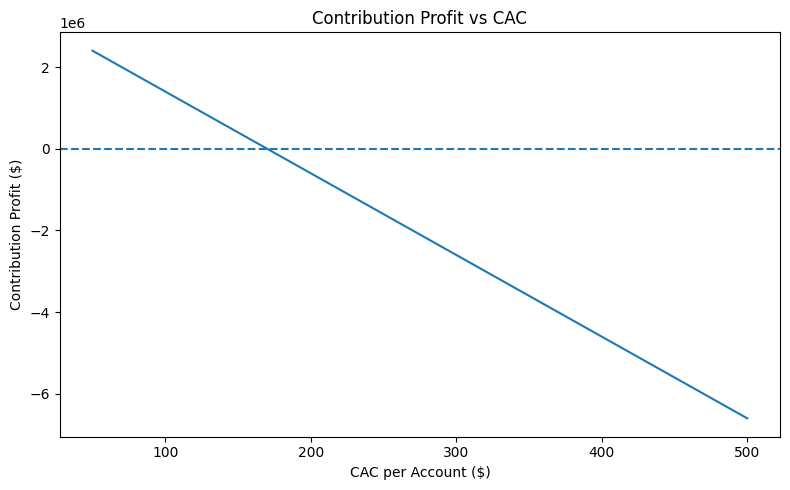

Maximum CAC for breakeven: 168.18


In [7]:
cacs = np.linspace(50, 500, 100)
profits_cac = []

for c in cacs:
    temp = base.model_copy(update={"cac_per_account": float(c)})
    d = result_to_dict(run_deterministic_unit_econ(temp))
    profits_cac.append(d["contribution_profit"])

profits_cac = np.array(profits_cac)

plt.figure(figsize=(8,5))
plt.plot(cacs, profits_cac)
plt.axhline(0, linestyle="--")
plt.title("Contribution Profit vs CAC")
plt.xlabel("CAC per Account ($)")
plt.ylabel("Contribution Profit ($)")
plt.tight_layout()
plt.show()

max_cac = cacs[np.where(profits_cac > 0)[0][-1]]
print("Maximum CAC for breakeven:", round(float(max_cac), 2))

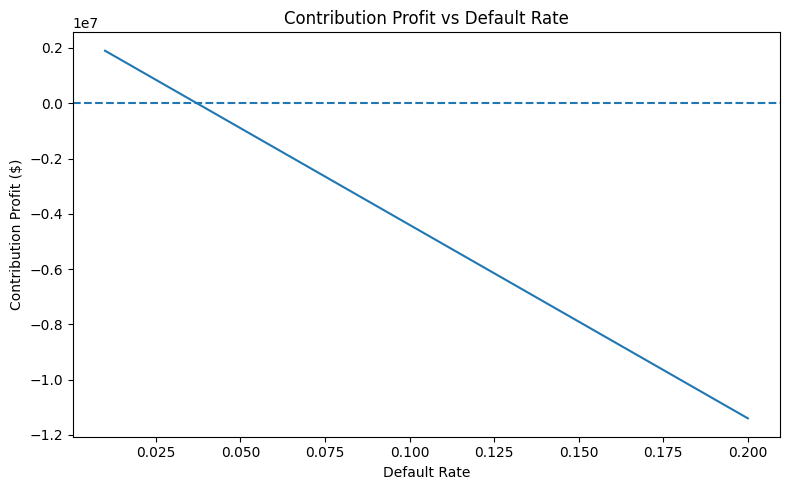

Maximum sustainable default rate: 0.0369


In [8]:
default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

drs = np.linspace(0.01, 0.20, 100)
profits_dr = []

for dr in drs:
    temp = base.model_copy(update={default_field: float(dr)})
    d = result_to_dict(run_deterministic_unit_econ(temp))
    profits_dr.append(d["contribution_profit"])

profits_dr = np.array(profits_dr)

plt.figure(figsize=(8,5))
plt.plot(drs, profits_dr)
plt.axhline(0, linestyle="--")
plt.title("Contribution Profit vs Default Rate")
plt.xlabel("Default Rate")
plt.ylabel("Contribution Profit ($)")
plt.tight_layout()
plt.show()

max_dr = drs[np.where(profits_dr > 0)[0][-1]]
print("Maximum sustainable default rate:", round(float(max_dr), 4))

In [9]:
default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

dr_grid = np.linspace(0.01, 0.15, 60)       # 1% to 15%
cac_grid = np.linspace(100, 400, 60)        # $100 to $400

profit_surface = np.zeros((len(cac_grid), len(dr_grid)))

for i, cac in enumerate(cac_grid):
    for j, dr in enumerate(dr_grid):
        temp = base.model_copy(update={
            default_field: float(dr),
            "cac_per_account": float(cac),
        })
        d = result_to_dict(run_deterministic_unit_econ(temp))
        profit_surface[i, j] = d["contribution_profit"]

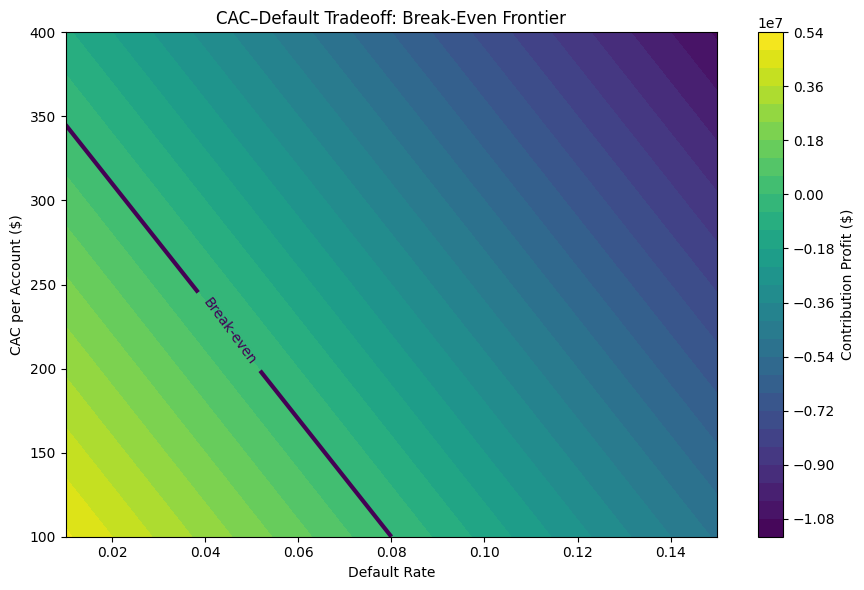

In [10]:
plt.figure(figsize=(9,6))

X, Y = np.meshgrid(dr_grid, cac_grid)

# Filled contour (color surface)
contour = plt.contourf(X, Y, profit_surface, levels=30)
plt.colorbar(contour, label="Contribution Profit ($)")

# Zero-profit line
zero_contour = plt.contour(X, Y, profit_surface, levels=[0], linewidths=3)
plt.clabel(zero_contour, fmt="Break-even", inline=True)

plt.title("CAC–Default Tradeoff: Break-Even Frontier")
plt.xlabel("Default Rate")
plt.ylabel("CAC per Account ($)")
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd

# --- Simulation parameters ---
N = 20000
rng = np.random.default_rng(42)

default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

# Baseline means (from base_case)
dr_mean = float(getattr(base, "default_rate", getattr(base, "annual_default_rate")))
cac_mean = float(base.cac_per_account)
fc_mean = float(base.funding_cost_rate)

# Standard deviations (same as Notebook 03)
dr_sd = 0.015
cac_sd = 40.0
fc_sd = 0.01

def truncated_normal(n, mean, sd, low, high, rng):
    out = np.empty(n)
    filled = 0
    while filled < n:
        draw = rng.normal(mean, sd, size=(n - filled) * 3)
        draw = draw[(draw >= low) & (draw <= high)]
        take = min(len(draw), n - filled)
        out[filled:filled + take] = draw[:take]
        filled += take
    return out

# Draw shocks
dr_draws = truncated_normal(N, dr_mean, dr_sd, 0.01, 0.30, rng)
cac_draws = truncated_normal(N, cac_mean, cac_sd, 50.0, 800.0, rng)
fc_draws = truncated_normal(N, fc_mean, fc_sd, 0.00, 0.25, rng)

profits = np.empty(N)

for i in range(N):
    temp = base.model_copy(update={
        default_field: float(dr_draws[i]),
        "cac_per_account": float(cac_draws[i]),
        "funding_cost_rate": float(fc_draws[i]),
    })
    d = result_to_dict(run_deterministic_unit_econ(temp))
    profits[i] = d["contribution_profit"]

baseline_sim = pd.DataFrame({"profit": profits})

baseline_sim.head()

,profit
0,-3.166957e+06
1,1.666199e+05
2,-3.437466e+06
3,-1.590363e+06
4,2.527091e+06


In [12]:
profit = baseline_sim["profit"].to_numpy()

expected_profit = float(profit.mean())
var_5 = float(np.quantile(profit, 0.05))
es_5 = float(profit[profit <= var_5].mean())

required_equity = abs(es_5)
raroc = expected_profit / required_equity

print("Baseline Capital Metrics")
print("-------------------------")
print(f"Expected Profit: ${expected_profit:,.0f}")
print(f"5% VaR: ${var_5:,.0f}")
print(f"5% ES (Capital Requirement Proxy): ${required_equity:,.0f}")
print(f"RAROC (Expected Profit / Required Equity): {raroc:.2%}")

Baseline Capital Metrics
-------------------------
Expected Profit: $-1,604,709
5% VaR: $-3,949,445
5% ES (Capital Requirement Proxy): $4,569,268
RAROC (Expected Profit / Required Equity): -35.12%


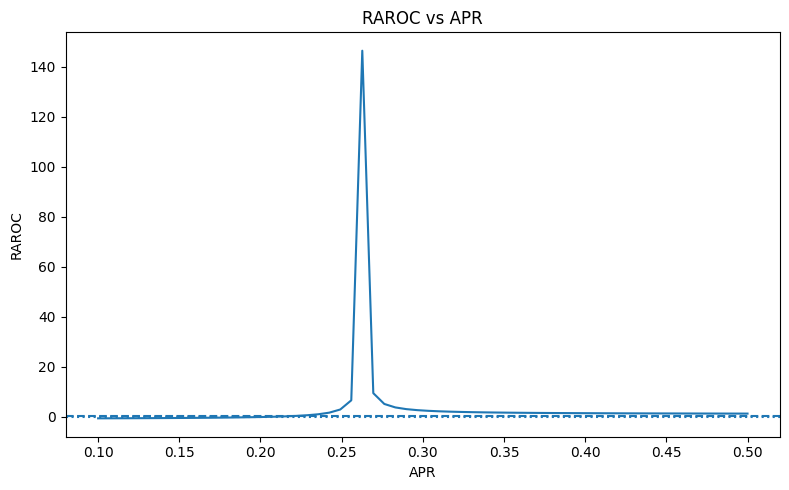

In [13]:
target_raroc = 0.15   # 15% capital return target
aprs = np.linspace(0.10, 0.50, 60)

rarocs = []

for apr in aprs:
    temp_base = base.model_copy(update={"apr": float(apr)})

    profits = np.empty(N)

    for i in range(N):
        temp = temp_base.model_copy(update={
            default_field: float(dr_draws[i]),
            "cac_per_account": float(cac_draws[i]),
            "funding_cost_rate": float(fc_draws[i]),
        })
        d = result_to_dict(run_deterministic_unit_econ(temp))
        profits[i] = d["contribution_profit"]

    expected_profit = profits.mean()
    var_5 = np.quantile(profits, 0.05)
    es_5 = profits[profits <= var_5].mean()
    required_equity = abs(es_5)

    rarocs.append(expected_profit / required_equity)

rarocs = np.array(rarocs)

plt.figure(figsize=(8,5))
plt.plot(aprs, rarocs)
plt.axhline(target_raroc, linestyle="--")
plt.axhline(0, linestyle=":")
plt.title("RAROC vs APR")
plt.xlabel("APR")
plt.ylabel("RAROC")
plt.tight_layout()
plt.show()

In [14]:
required_apr = aprs[np.where(rarocs > target_raroc)[0][0]]
print("APR required for 15% RAROC:", round(float(required_apr), 4))

APR required for 15% RAROC: 0.222


In [15]:
N = 20000
rng = np.random.default_rng(123)

default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

# Means
dr_mean = float(getattr(base, default_field))
cac_mean = float(base.cac_per_account)
fc_mean = float(base.funding_cost_rate)

# Standard deviations
dr_sd = 0.015
cac_sd = 40.0
fc_sd = 0.01

# Correlation strength parameters
beta_dr = 1.0
beta_cac = 0.8
beta_fc = 0.6

# Draw common macro factor
Z = rng.normal(0, 1, N)

# Idiosyncratic shocks
eps_dr = rng.normal(0, 1, N)
eps_cac = rng.normal(0, 1, N)
eps_fc = rng.normal(0, 1, N)

# Construct correlated draws
dr_draws_corr = dr_mean + dr_sd * (beta_dr * Z + 0.5 * eps_dr)
cac_draws_corr = cac_mean + cac_sd * (beta_cac * Z + 0.5 * eps_cac)
fc_draws_corr = fc_mean + fc_sd * (beta_fc * Z + 0.5 * eps_fc)

# Truncate to reasonable ranges
dr_draws_corr = np.clip(dr_draws_corr, 0.01, 0.30)
cac_draws_corr = np.clip(cac_draws_corr, 50, 800)
fc_draws_corr = np.clip(fc_draws_corr, 0.00, 0.25)

In [16]:
profits_corr = np.empty(N)

for i in range(N):
    temp = base.model_copy(update={
        default_field: float(dr_draws_corr[i]),
        "cac_per_account": float(cac_draws_corr[i]),
        "funding_cost_rate": float(fc_draws_corr[i]),
    })
    d = result_to_dict(run_deterministic_unit_econ(temp))
    profits_corr[i] = d["contribution_profit"]

corr_sim = pd.DataFrame({"profit": profits_corr})

In [17]:
profit_indep = baseline_sim["profit"].to_numpy()
profit_corr = corr_sim["profit"].to_numpy()

def risk_metrics(p):
    exp = p.mean()
    var = np.quantile(p, 0.05)
    es = p[p <= var].mean()
    return exp, var, es

exp_i, var_i, es_i = risk_metrics(profit_indep)
exp_c, var_c, es_c = risk_metrics(profit_corr)

print("Independent ES:", f"${abs(es_i):,.0f}")
print("Correlated ES:", f"${abs(es_c):,.0f}")
print("Change in Required Equity:", f"${abs(es_c)-abs(es_i):,.0f}")

Independent ES: $4,569,268
Correlated ES: $5,993,046
Change in Required Equity: $1,423,778


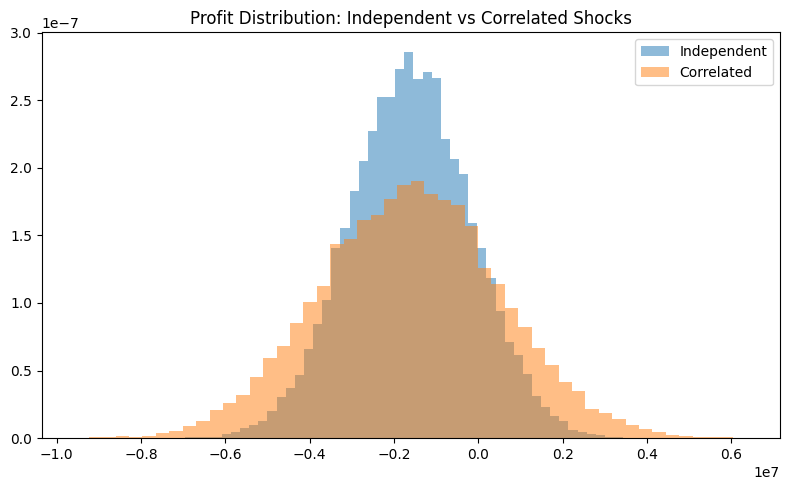

In [18]:
plt.figure(figsize=(8,5))
plt.hist(profit_indep, bins=50, alpha=0.5, density=True, label="Independent")
plt.hist(profit_corr, bins=50, alpha=0.5, density=True, label="Correlated")
plt.legend()
plt.title("Profit Distribution: Independent vs Correlated Shocks")
plt.tight_layout()
plt.show()

In [19]:
rho_values = np.linspace(0, 1.5, 15)

capital_required = []
rarocs = []

for rho in rho_values:

    Z = rng.normal(0, 1, N)
    eps_dr = rng.normal(0, 1, N)
    eps_cac = rng.normal(0, 1, N)
    eps_fc = rng.normal(0, 1, N)

    dr = dr_mean + dr_sd * (rho * beta_dr * Z + 0.5 * eps_dr)
    cac = cac_mean + cac_sd * (rho * beta_cac * Z + 0.5 * eps_cac)
    fc = fc_mean + fc_sd * (rho * beta_fc * Z + 0.5 * eps_fc)

    dr = np.clip(dr, 0.01, 0.30)
    cac = np.clip(cac, 50, 800)
    fc = np.clip(fc, 0.00, 0.25)

    profits = np.empty(N)

    for i in range(N):
        temp = base.model_copy(update={
            default_field: float(dr[i]),
            "cac_per_account": float(cac[i]),
            "funding_cost_rate": float(fc[i]),
        })
        d = result_to_dict(run_deterministic_unit_econ(temp))
        profits[i] = d["contribution_profit"]

    expected_profit = profits.mean()
    var_5 = np.quantile(profits, 0.05)
    es_5 = profits[profits <= var_5].mean()
    required_equity = abs(es_5)

    capital_required.append(required_equity)
    rarocs.append(expected_profit / required_equity)

capital_required = np.array(capital_required)
rarocs = np.array(rarocs)

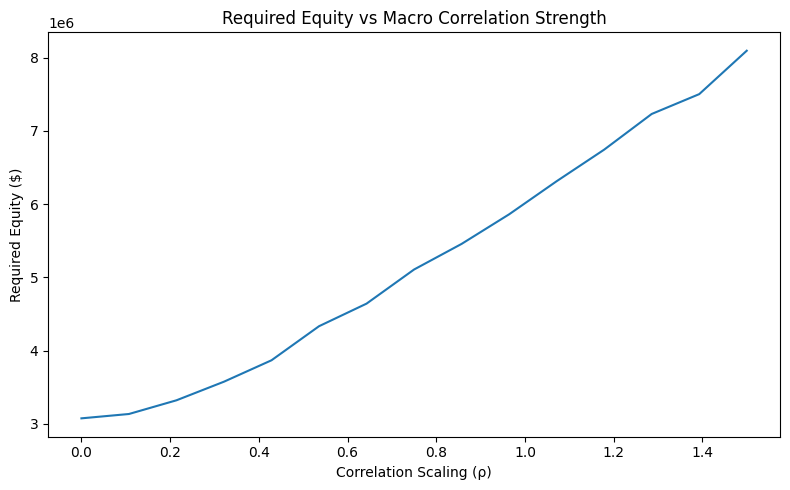

In [20]:
plt.figure(figsize=(8,5))
plt.plot(rho_values, capital_required)
plt.title("Required Equity vs Macro Correlation Strength")
plt.xlabel("Correlation Scaling (ρ)")
plt.ylabel("Required Equity ($)")
plt.tight_layout()
plt.show()

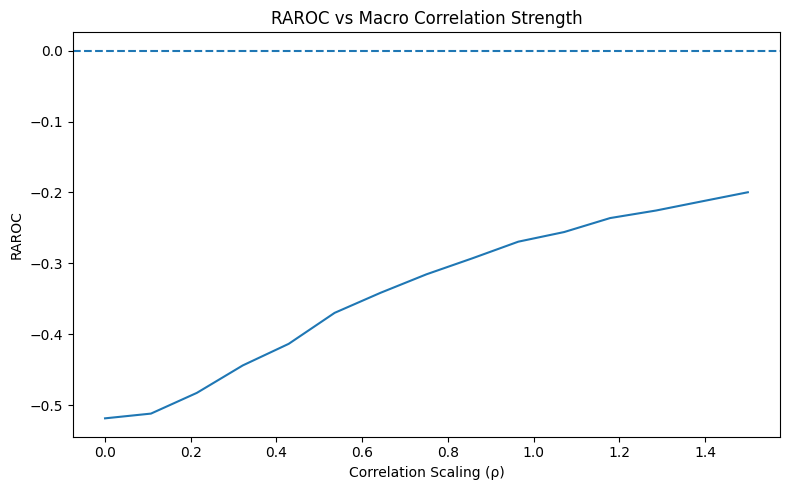

In [21]:
plt.figure(figsize=(8,5))
plt.plot(rho_values, rarocs)
plt.axhline(0, linestyle="--")
plt.title("RAROC vs Macro Correlation Strength")
plt.xlabel("Correlation Scaling (ρ)")
plt.ylabel("RAROC")
plt.tight_layout()
plt.show()

In [22]:
required_apr_15 = apr

In [23]:
# ===============================
# Executive Summary (Formatted)
# ===============================

apr_15_raroc = 0.222  # from your earlier result

summary_table = pd.DataFrame(
    {
        "Metric": [
            "Expected Profit",
            "Probability of Loss",
            "VaR (5%)",
            "Expected Shortfall (5%)",
            "Required Equity (ES)",
            "RAROC",
            "Break-Even APR",
            "APR for 15% RAROC",
        ],
        "Value_raw": [
            expected_profit,
            prob_loss,
            var_5,
            es_5,
            required_equity,
            raroc,
            float(break_even_apr),
            float(apr_15_raroc),
        ],
    }
)

def fmt_row(metric: str, x: float) -> str:
    if metric in ["Expected Profit", "VaR (5%)", "Expected Shortfall (5%)", "Required Equity (ES)"]:
        return f"${x:,.0f}"
    if metric in ["Probability of Loss", "RAROC"]:
        return f"{x:.1%}"
    if "APR" in metric:
        return f"{x:.1%}"
    return str(x)

summary_table["Value"] = [
    fmt_row(m, float(v)) for m, v in zip(summary_table["Metric"], summary_table["Value_raw"])
]

# Display the clean version
summary_table[["Metric", "Value"]]

NameError: name 'prob_loss' is not defined

In [ ]:
# ===============================
# Save tables (raw + formatted)
# ===============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")

raw_out = summary_table[["Metric", "Value_raw"]].copy()
fmt_out = summary_table[["Metric", "Value"]].copy()

raw_out.to_csv(TAB_DIR / f"{timestamp}_executive_summary_raw.csv", index=False)
fmt_out.to_csv(TAB_DIR / f"{timestamp}_executive_summary_formatted.csv", index=False)

print("Saved:")
print(" -", TAB_DIR / f"{timestamp}_executive_summary_raw.csv")
print(" -", TAB_DIR / f"{timestamp}_executive_summary_formatted.csv")

Saved:
 - C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\tables\2026-02-25_2039_executive_summary_raw.csv
 - C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\tables\2026-02-25_2039_executive_summary_formatted.csv


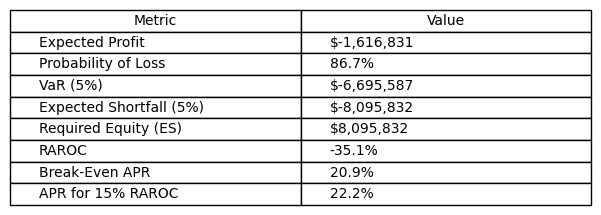

Saved image: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\figures\2026-02-25_2039_executive_summary_table.png


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 2.2))
ax.axis("off")

table_data = fmt_out.values.tolist()
col_labels = fmt_out.columns.tolist()

tbl = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc="left",
    loc="center",
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

img_path = FIG_DIR / f"{timestamp}_executive_summary_table.png"
plt.savefig(img_path, dpi=250, bbox_inches="tight")
plt.show()

print("Saved image:", img_path)